# Classifying States in Cygnus X-1

Aims:
- Unsupervised classification of Cygnus X-1 states based on pointed observations (usually derived from parameters by hand)
- How many distinct states are there (i.e. does the intermediate state exist)?
- Do the hard and soft states change with time: do they look the same over the entire lifetime of the observations?
- which features decide on whether a source is in a soft, intermediate or hard state?
- should we use the clean biweekly sample or can we use the earlier data taken in a different mode?

We might need to refine these questions as we go.

The data we have are:
- data are satellite orbit by satellite orbit, average exposure 1.6-1.7 ks
- 2015 individual observations, each of which make a single sample (feature vector)
- data consist of:
    - light curves
    - spectral fits
    - hardnesses if necessary

Need to decide:
- which features to include
- whether to include spectral fit parameters
- whether to include radio emission
- do feature engineering, throw out features that don't add anything, run unsupervised classification on restricted feature set, but check back with full feature set whether the unsupervised classification changes significantly!


## Visualisation of our basic feature space

Our feature space is this, and combinations of this (these are the columns in data file `data_for_ml.dat`:

1. Blockname (identifier for observation)
2. Gamma_1 (photon index from spectral fits; equivalent to state label: Gamma_1 <= 2.0 hard state, 2.0 < Gamma_1 <= 2.5 intermediate state, 2.5 <= soft state)
3. start time
4. stop time

5. rms in 0.125–256 Hz range in the 2.1-4.5 keV energy band
6. rms in 0.125–256 Hz range in the 4.5-5.7 keV energy band
7. rms in 0.125–256 Hz range in the 5.7-9.4 keV energy band
8. rms in 0.125–256 Hz range in the 9.4-15 keV energy band

9. rms in 0.25–2 Hz range in the 2.1-4.5 keV energy band
10. rms in 2-16 Hz range in the 2.1-4.5 keV energy band

11. average timelag in 3.2-10 Hz range (9.4-15 keV vs. 2.1-4.5 keV)
12. average coherence in 3.2-10 Hz range (9.4-15 keV vs. 2.1-4.5 keV)

13. average countrate in 2.1-4.5 keV energy band
14. average countrate in 4.5-5.7 keV energy band
15. average countrate in 5.7-9.4 keV energy band
16. average countrate in 9.4-15 keV energy band


We're going to use hardness ratios instead of count rates, where 

HR1 = (average countrate in 9.4-15 keV energy band)/(average countrate in 2.1-4.5 keV energy band)

and

HR2 = (average countrate in 5.7-9.4 keV energy band)/(average countrate in 2.1-4.5 keV energy band)

and

HR3 = (average countrate in 9.4-15 keV energy band)/(average countrate in 4.5-5.7 keV energy band)

and

HR4 = (average countrate in 5.7-9.4 keV energy band)/(average countrate in 4.5-5.7 keV energy band)

We're also going to work with the sum as a proxy for the total intensity:

SUM = 13 + 14 + 15 + 16

We're also going to look at Power Colours:

PC1 = (rms in 2-16 Hz range in the 2.1-4.5 keV energy band)/(rms in 0.25–2 Hz range in the 2.1-4.5 keV energy band)


In [2]:
## Imports
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import generaltools as gt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model 
from sklearn.manifold import TSNE

In [3]:
## first row is strings, put that separately
data1= gt.conversion("data_for_ml.txt")
blockname = np.array(data1[0])

In [4]:
## load in all other columns as a numpy.array
data = np.loadtxt("data_for_ml.txt", usecols=range(1,len(data1.keys()),1))

### Dealing with Calibration Error

The first calibration epoch for RXTE is weird, which leads to interesting effects in the features making them look more distinct than they are (i.e. the data might be in the same state, but look different because of calibration differences). For now, we're going to throw out those data in order to work with a clean data set and think about how to incorporate calibration issues later. 

We'll exclude all data before MJD $51259$.

In [5]:
cal_ind = data[:,1].searchsorted(51259.0)
data = data[cal_ind:,:]
print(data.shape)
blockname = blockname[cal_ind:]
print(len(blockname))

(1944, 16)
1944


Sometimes, the coherence goes to crazy values. These values are not actually real, but a computation error. These are also observations we'll throw away for now. 

In [6]:
co_ind = np.where((data[:,10] > 0.0) & (data[:,10] < 2.0))[0]
#blockname = blockname[co_ind]
data = data[co_ind,:]
blockname = [b for i,b in enumerate(blockname) if i in co_ind]

Now we can extract the individual features and combine then to useful things.

In [7]:
gammas = data[:,0]
tstart = data[:,1]
tend = data[:,2]

rms_features = np.atleast_2d(data[:,3:7]).T

pc1 = np.atleast_2d(data[:,8]/data[:,7])

timelag = np.atleast_2d(data[:,9])
coherence = np.atleast_2d(data[:,10])
intensity = np.atleast_2d(np.sum(data[:,11:], axis=1))

hr1 = np.atleast_2d(data[:,14]/data[:,11])
hr2 = np.atleast_2d(data[:,13]/data[:,11])
hr3 = np.atleast_2d(data[:,14]/data[:,12])
hr4 = np.atleast_2d(data[:,13]/data[:,12])

countrate_features = np.atleast_2d(data[:,11:-1]).T
pc_components = np.atleast_2d(data[:,7:9]).T

## is there a disk in the spectrum?
disk = data[:,-1]



In [8]:
data.shape

(1936, 16)

We're going to define the labels using the photon index of the spectral fits:
- hard state: $\Gamma_1 \leq 2.0$
- intermediate state: $2.0 < \Gamma_1 < 2.5$
- soft state: $\Gamma_1 \geq 2.5$

In [9]:
## extract different states from the 
states = np.zeros(len(gammas))
hard = np.where(gammas <= 2.0)[0]
intermediate = np.where((gammas>2.0) & (gammas<2.5))[0]
soft = np.where(gammas >= 2.5)[0]

states[hard] = 1.0
states[intermediate] = 2.0
states[soft] = 3.0

states = np.atleast_2d(states)


(array([ 1268.,   284.,   384.]),
 array([ 1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 3 Patch objects>)

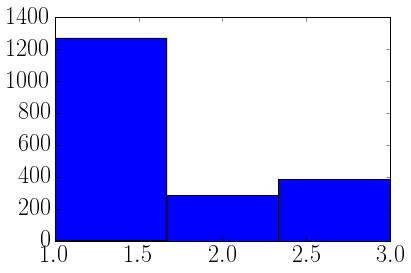

In [10]:
plt.hist(list(states), bins=3, range=[1,3])

Now we're going to combine the stuff we want to a feature vector.

In [11]:
features = np.concatenate((states, rms_features, pc1, timelag, coherence, 
                           intensity, hr1, hr2, hr3, hr4, countrate_features, 
                           pc_components)).T

In [12]:
### scale features
scaler_train = StandardScaler().fit(features[:,1:])
fscaled = scaler_train.transform(features[:,1:])


### Running t-SNE on the raw features space

In [13]:
tsne = TSNE()
asdf = tsne.fit_transform(fscaled)

In [14]:
f = open("cygx1_tsne.dat", "w")
import cPickle as pickle
pickle.dump([tsne, asdf], f, -1)
f.close()

In [15]:
tsne, asdf = gt.getpickle("cygx1_tsne.dat")

In [16]:
## make dictionary to put into thingy
import pandas as pd
d = {}
d["blockname"] = blockname
d["tstart"] = tstart
d["tend"] = tend
d["gammas"] = gammas
d["pc1"] = pc1[0,:]
d["timelag"] = timelag[0,:]
d["coherence"] = coherence[0,:]
d["intensity"] = intensity[0,:]
d["hr1"] = hr1[0,:]
d["hr2"]= hr2[0,:]
d["hr3"] = hr3[0,:]
d["hr4"] = hr4[0,:]
d["states"] = states[0,:]
d["asdf0"] = asdf[:,0]
d["asdf1"] = asdf[:,1]
d["disk"] = disk
df = pd.DataFrame(d)

List of states:[1.0, 2.0, 3.0]


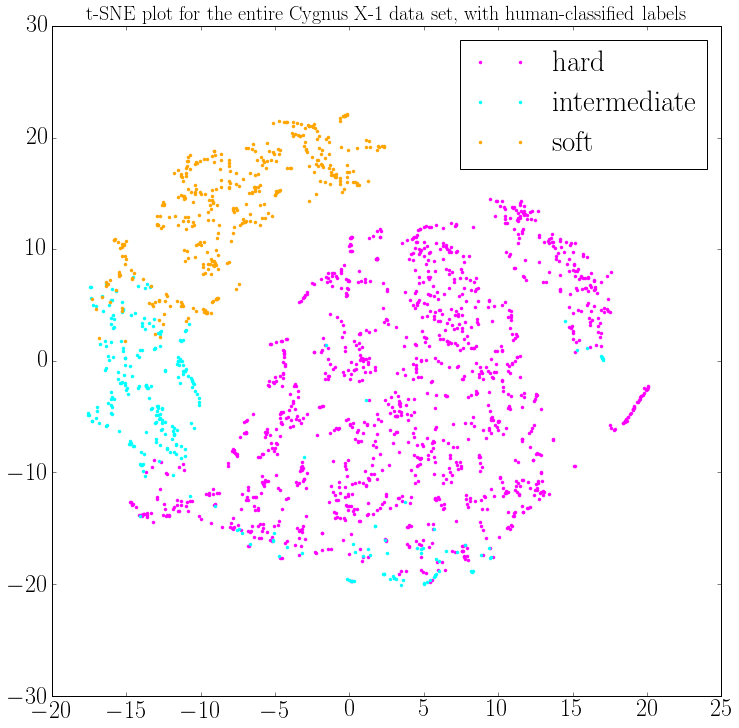

In [17]:

state_set = list(set(states[0,:]))
print("List of states:" + str(state_set))
plt.figure(figsize=(12, 12))

colors = ["magenta", "cyan", "orange"]

for k, col in zip(range(len(state_set)), colors):
    my_members = states[0,:] == k+1
    #cluster_center = cluster_centers[k]
    plt.plot(asdf[my_members, 1], asdf[my_members, 0],".", color=col)
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)
plt.legend(["hard", "intermediate", "soft"])
#plt.show()

plt.title("t-SNE plot for the entire Cygnus X-1 data set, with human-classified labels")
#plt.savefig("cygx1_tsne.png", format="png", transparent=False)
#plt.close()

In [18]:
from bokeh.plotting import ColumnDataSource, figure, output_notebook, show
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

In [19]:
colors = ["magenta", "cyan", "orange"]

p = figure(title = "Cygnus X-1, t-SNE plot with human labels",
           #x_axis_label = "Time in MET seconds",
           #y_axis_label = "Counts per bin?",
           #background_fill="lightgrey",
           tools="pan,wheel_zoom,box_zoom,reset,hover")

#colors = sns.color_palette("hls", 8)
colours = ["red", "green", "blue"]#, "yellow", "brown", "cyan", "orange", "black"]

#for k, col in zip(pred_label_set, colors):
#    print("k: " + str(k))
#    my_members = pred_labels == k
#    print(len(my_members))
#    #cluster_center = cluster_centers[k]
#    p.scatter(asdf[my_members, 0], asdf[my_members, 1], fill_color=col, line_color=col, fill_alpha=0.9)
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    #         markeredgecolor='k', markersize=14)

#colors = ["mediumseagreen", "navy", "mediumorchid", "sienna", "teal", "goldenrod", "grey", "black"]
cnew = [colors[int(i)-1] for i in states[0,:]]

source = ColumnDataSource(data=d)  


#p.scatter(x = asdf[:,0], y = asdf[:,1], size=4, fill_color=cnew, line_color=cnew, alpha=0.5)
p.scatter(x=asdf[:,0], y=asdf[:,1], source=source, size=4, fill_color=cnew, line_color=cnew, alpha=0.5)

#hover = p.select(dict(type=HoverTool))
#hover.tooltips = [("states", "@states"),
#                ("","$x"),
#                ("KO","$y")]

#show(p)
hover = p.select(dict(type=HoverTool))
hover.tooltips = [("block name", "@blockname"),
                  ("Start Time", "@tstart"),
                  ("State", "@states"),
                ("Gamma_1","@gammas"),
                ("Timelag","@timelag"),
                ("Coherence", "@coherence"),
                ("Intensity", "@intensity"),
                ("HR1", "@hr1"),
                ("HR2", "@hr2"),
                ("HR3", "@hr3"),
                ("HR4", "@hr4"),
                ]

show(p)

## Feature Engineering

It's time to play with features. For this purpose, we'll look at all the individual features and evaluate how important they are for determining different classes using supervised learning (Random Forest) on the classified data set. 

In [31]:
# shuffle features to get rid of time ordering
#np.random.shuffle(features)

## separate out training and test data set
nsamples = fscaled.shape[0]
train_frac = 0.6
f_train = features[:train_frac*nsamples,1:]
l_train = features[:train_frac*nsamples,0]
print(f_train.shape)

f_test = features[train_frac*nsamples:, 1:]
l_test = features[train_frac*nsamples:, 0]
print(f_test.shape)
### scale features

scaler = StandardScaler().fit(features[:,1:])
fscaled_train = scaler.transform(f_train)
fscaled_test = scaler.transform(f_test)

fscaled = scaler.transform(features[:,1:])


(1161, 18)
(775, 18)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Now we can run the random forest. Let's try it on all features first and see how well it does.

In [34]:
params = {'max_depth': [7,10,12, 15,17, 18, 19, 20, 21, 22, 23, 25,30,40, 50, 100, 200, 500, 1000]}#,
         # 'max_features':[2,3,4,5,6,7,8,10,50,150,200,250,300]}
grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid=params,
                        verbose=0, n_jobs=10)
#rfc = RandomForestClassifier(n_estimators=500, max_depth=10)
#rfc.fit(fscaled_train, labels_train)
grid_rfc.fit(fscaled_train, l_train)
print("Best results for the Random Forest run:")
print("Best parameter: " + str(grid_rfc.best_params_))
print("Training accuracy: " + str(grid_rfc.score(fscaled_train, l_train)))
print("Validation accuracy: " + str(grid_rfc.score(fscaled_test, l_test)))


Best results for the Random Forest run:
Best parameter: {'max_depth': 12}
Training accuracy: 1.0
Validation accuracy: 0.969032258065


Next, we can do a greedy search through all the parameters and see which features contribute most to the classification. First, we'll classify on a single feature, going through all features and picking the one that does best on its own. Next, we'll add a second feature, testing combinations of the one we picked and every other feature that's left over and pick the best combination. We'll continue this way until we've got a ranking for all features.

In [35]:
fscaled_train.shape

(1161, 18)

In [36]:
score_all = []
feature_ranking = []
nfeatures = range(fscaled_train.shape[1]-1)
features_new_train = []
features_new_val = []
features_new_test = []
best_params_all = []

for i in range(fscaled_train.shape[1]-1):
    i+=1
    score = []
    best_params = []
    ## first feature
    for j in nfeatures:
        j+=1
        if len(features_new_train) == 0:
            ft = np.atleast_2d(fscaled_train[:,j]).T
            #fv = np.atleast_2d(features_val[:,j]).T
            fte = np.atleast_2d(fscaled_test[:,j]).T
        else:
            ft = np.concatenate((features_new_train, ft), 1)
            #fv = np.concatenate((features_new_val, fv), 1)
            fte = np.concatenate((features_new_test, fte), 1)
        #print(ft.shape)
        #print(fv.shape)
        ### scale features
        f_all = np.concatenate((ft, fte))
        scaler = StandardScaler().fit(f_all)
        fts = scaler.transform(ft)
        #print(fscaled_train.shape)

        #scaler_val = StandardScaler().fit(fv)
        ftes = scaler.transform(fte)
        #print(fscaled_val.shape)
        ### Random Forest Classifier
        params = {'max_depth': [3,5,7,10,15,20,30,50,75,100,150,200,250,300,400]}#,
        grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid=params,
                                verbose=0, n_jobs=4)
        #rfc = RandomForestClassifier(n_estimators=500, max_depth=10)
        #rfc.fit(fscaled_train, labels_train)
        grid_rfc.fit(fts, l_train)
        #print("Best results for the Random Forest run:")
        #print("Best parameter: " + str(grid_rfc.best_params_))
        best_params.append(grid_rfc.best_params_)
        print("Training accuracy: " + str(grid_rfc.score(fts, l_train)))
        print("Validation accuracy: " + str(grid_rfc.score(ftes, l_test)))
        score.append(grid_rfc.score(ftes, l_test))
    
    score_all.append(score)
    best_params_all.append(best_params)
    best_ind = np.where(score == np.max(score))[0]
    print("best_ind: " + str(best_ind))
    if len(best_ind) > 1:
        best_ind = best_ind[0]
    print("The best score in round " + str(i) + " is " + str(np.max(score)))
    n_best = nfeatures.pop(best_ind)
    print("The best-ranked feature in round " + str(i) + " is " + str(n_best))
    feature_ranking.append(n_best)
    if len(features_new_train) == 0:
        features_new_train = np.atleast_2d(fscaled_train[:,n_best]).T
        #features_new_val = np.atleast_2d(features_val[:,n_best]).T
        features_new_test = np.atleast_2d(fscaled_test[:,n_best]).T
    else:
        features_new_train = np.concatenate((features_new_train, np.atleast_2d(f_train[:,n_best]).T), 1)
        #features_new_val = np.concatenate((features_new_val, np.atleast_2d(features_val[:,n_best]).T), 1)
        features_new_test = np.concatenate((features_new_test, np.atleast_2d(f_test[:,n_best]).T), 1)


Training accuracy: 0.817398794143
Validation accuracy: 0.870967741935
Training accuracy: 0.774332472007
Validation accuracy: 0.745806451613
Training accuracy: 0.820844099914
Validation accuracy: 0.727741935484
Training accuracy: 0.819982773471
Validation accuracy: 0.735483870968
Training accuracy: 0.787252368648
Validation accuracy: 0.725161290323
Training accuracy: 0.781223083549
Validation accuracy: 0.721290322581
Training accuracy: 0.757105943152
Validation accuracy: 0.722580645161
Training accuracy: 0.94315245478
Validation accuracy: 0.970322580645
Training accuracy: 0.92420327304
Validation accuracy: 0.967741935484
Training accuracy: 0.942291128338
Validation accuracy: 0.954838709677
Training accuracy: 0.905254091301
Validation accuracy: 0.947096774194
Training accuracy: 0.799310938846
Validation accuracy: 0.745806451613
Training accuracy: 0.714900947459
Validation accuracy: 0.714838709677
Training accuracy: 0.675279931094
Validation accuracy: 0.716129032258
Training accuracy: 0.6

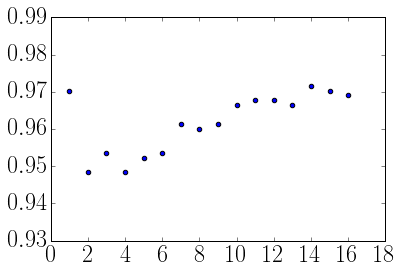

In [37]:
score_max = [np.max(s) for s in score_all[:-1]]
#score_std = [np.std(s) for s in score_all[:-1]]
plt.scatter(np.arange(len(score_max))+1, score_max)



In [ ]:
score_max = [np.max(s) for s in score_all[:-1]]
plt.plot(np.arange(len(score_max))+1, score_max)
plt.savefig("cygx1_feature_engineering3.pdf", format="pdf")
plt.close()
np.savetxt("cygx1_feature_ranking3.dat", feature_ranking)

For several trial runs, we see that the first feature manages to get up to an accuracy of $~97\%$. However, in all trial runs, the second feature we add actually **decreases** the accuracy by about three percent before it slowly inches back up. We don't understand why. **Ask Andy about this**. 

## Unsupervised Learning

Before we go to bed, we'll try out some clustering just for fun

In [56]:
features_new = np.vstack([features_new_train, features_new_test])
labels_new = np.hstack([l_train, l_test])

In [91]:
scaler = StandardScaler().fit(features_new)
fscaled_new = scaler.transform(features_new)[:,:6]
fscaled_new_train = scaler.transform(features_new_train)[:,:6]
fscaled_new_test = scaler.transform(features_new_test)[:,:6]

In [58]:
from sklearn.mixture import GMM

In [59]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GMM

covar_type = "full"

#scaler = StandardScaler().fit(features)

#fscaled = scaler.transform(features)


kmc = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmc.fit(fscaled_new)
pred_labels_kmeans = kmc.labels_
pred_label_set = list(set(pred_labels_kmeans))
print("Rand Index adjusted for chance: " + str(metrics.adjusted_rand_score(labels_new, pred_labels_kmeans+1)))

gmmc = GMM(n_components=3, covariance_type=covar_type, n_iter=100)
gmmc.fit(fscaled_new)
bic = gmmc.bic(fscaled_new)
#bic_all.append(bic)
pred_labels_gmm = gmmc.predict(fscaled_new)
#pred_labels_all.append(pred_labels)
print("Rand Index adjusted for chance: " + str(metrics.adjusted_rand_score(labels_new, pred_labels_gmm+1)))


Rand Index adjusted for chance: 0.724746482865
Rand Index adjusted for chance: 0.702707472763


(array([ 1085.,   479.,   372.]),
 array([ 1.,  2.,  3.,  4.]),
 <a list of 3 Patch objects>)

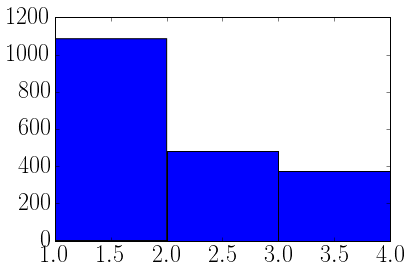

In [60]:
plt.hist(pred_labels_gmm+1., bins=len(pred_label_set), range=[1,4])

In [61]:
from bokeh.plotting import gridplot

#p = figure(title = "Cygnus X-1, t-SNE plot with human labels",
           #x_axis_label = "Time in MET seconds",
           #y_axis_label = "Counts per bin?",
           #background_fill="lightgrey",
#           tools="pan,wheel_zoom,box_zoom,reset,hover")

colors = ["magenta", "cyan", "orange", "mediumseagreen", "purple"]#, "yellow", "brown", "cyan", "orange", "black"]


colors = ["mediumseagreen", "navy", "mediumorchid", "orange", "sienna", "teal", "goldenrod", "grey", "black"]
colors2 = ["orange", "black", "blue"]
cnew_kmeans = [colors[int(i)] for i in pred_labels_kmeans]
#cnew_gmm = [colors[int(i)] for i in pred_labels_gmm]
cnew_gmm = [colors2[int(i)] for i in pred_labels_gmm]

source = ColumnDataSource(data=d)  

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select, hover"

#p.scatter(x=asdf[:,0], y=asdf[:,1], source=source, size=4, fill_color=cnew, line_color=cnew, alpha=0.5)
s1 = figure(tools=TOOLS, plot_width=500, plot_height=500)
s1.scatter(x="asdf0", y="asdf1", source=source, color=cnew_kmeans)

#s2 = figure(tools=TOOLS, plot_width=500, plot_height=500)
#s2.scatter(x="asdf0", y="asdf1", source=source, color=cnew_gmm)

hover = s1.select(dict(type=HoverTool))
hover.tooltips = [("block name", "@blockname"),
                  ("Start Time", "@tstart"),
                  ("State", "@states"),
                ("Gamma_1","@gammas"),
                ("Timelag","@timelag"),
                ("Coherence", "@coherence"),
                ("Intensity", "@intensity"),
                ("HR1", "@hr1"),
                ("HR2", "@hr2"),
                ("HR3", "@hr3"),
                ("HR4", "@hr4"),
                ]



#misclassifieds = np.where(pred_labels+1. != features[:,0])
#p = gridplot([[s1,s2]])
#show(p)
show(s1)


In [62]:
from bokeh.plotting import gridplot

#p = figure(title = "Cygnus X-1, t-SNE plot with human labels",
           #x_axis_label = "Time in MET seconds",
           #y_axis_label = "Counts per bin?",
           #background_fill="lightgrey",
#           tools="pan,wheel_zoom,box_zoom,reset,hover")

colors = ["magenta", "cyan", "orange", "mediumseagreen", "purple"]#, "yellow", "brown", "cyan", "orange", "black"]


colors = ["mediumseagreen", "navy", "mediumorchid", "orange", "sienna", "teal", "goldenrod", "grey", "black"]
cnew_kmeans = [colors[int(i)] for i in pred_labels_kmeans]
cnew_gmm = [colors[int(i)] for i in pred_labels_gmm]


source = ColumnDataSource(data=d)  

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select, hover"

#p.scatter(x=asdf[:,0], y=asdf[:,1], source=source, size=4, fill_color=cnew, line_color=cnew, alpha=0.5)
s1 = figure(tools=TOOLS, plot_width=500, plot_height=500)
s1.scatter(x="asdf0", y="asdf1", source=source, color=cnew_gmm )

#s1.quad(top="state_hist", bottom=0, left="state_edges_left", right="state_edges_right",
#    fill_color="#036564", line_color="#033649", source=source_lb)

#s2 = figure(tools=TOOLS, plot_width=500, plot_height=500)
#s2.scatter(x="asdf0", y="asdf1", source=source, color=cnew_gmm)
hover = s1.select(dict(type=HoverTool))
hover.tooltips = [("block name", "@blockname"),
                  ("Start Time", "@tstart"),
                  ("State", "@states"),
                ("Gamma_1","@gammas"),
                ("Timelag","@timelag"),
                ("Coherence", "@coherence"),
                ("Intensity", "@intensity"),
                ("HR1", "@hr1"),
                ("HR2", "@hr2"),
                ("HR3", "@hr3"),
                ("HR4", "@hr4"),
                ]



#misclassifieds = np.where(pred_labels+1. != features[:,0])
#p = gridplot([[s1,s2]])
#show(p)
show(s1)


In [42]:
print(cnew_kmeans[:10])
print(cnew_gmm[:10])

['mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']
['mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid', 'mediumorchid']


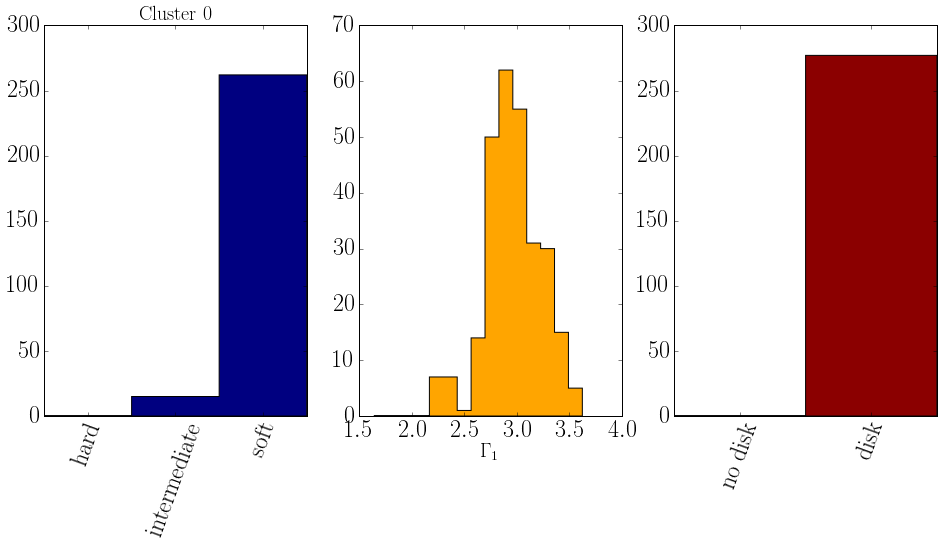

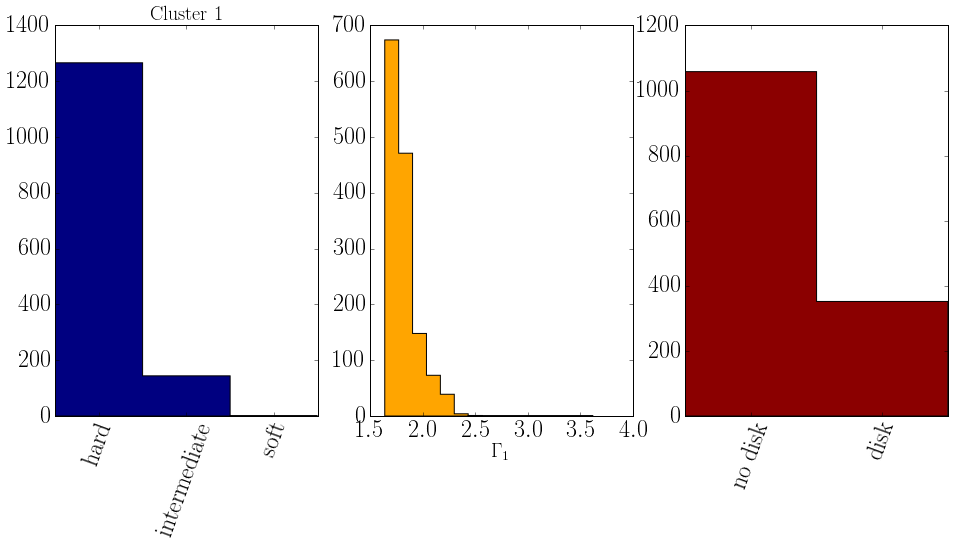

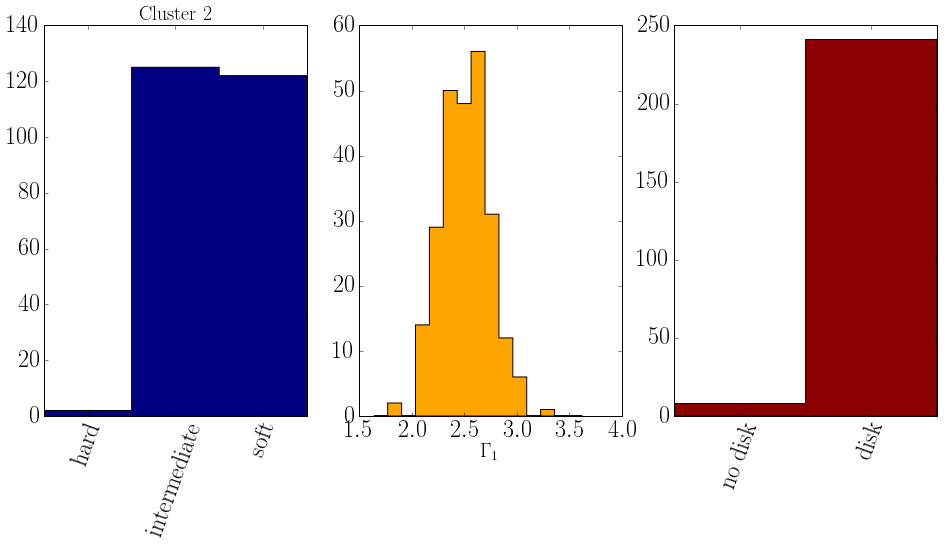

In [63]:
for p in pred_label_set:
    mymembers = pred_labels_kmeans == p
    pstates = states[0,mymembers]
    pgammas = gammas[mymembers]
    pdisk = disk[mymembers]
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(131)
    ax.hist(pstates, bins=3, range=[0.5,3.5], histtype="stepfilled", color="navy")
    ax.set_title("Cluster %s"%p)
    plt.xticks([1, 2, 3], ["hard", "intermediate", "soft"], rotation=70)
    ax2 = fig.add_subplot(132)
    ax2.hist(pgammas, bins=15, range=[np.min(gammas), np.max(gammas)],color="orange", histtype="stepfilled")
    ax2.set_xlabel("$\Gamma_1$")
    ax3 = fig.add_subplot(133)
    ax3.hist(pdisk+1, bins=2, range=[0.5,2.5], histtype="stepfilled", color="darkred")
    plt.xticks([1, 2], ["no disk", "disk"], rotation=70)



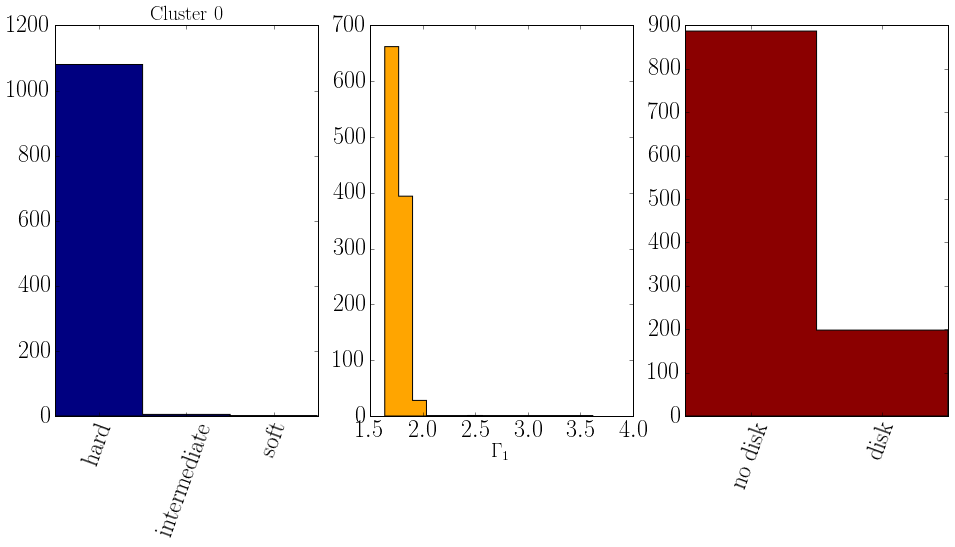

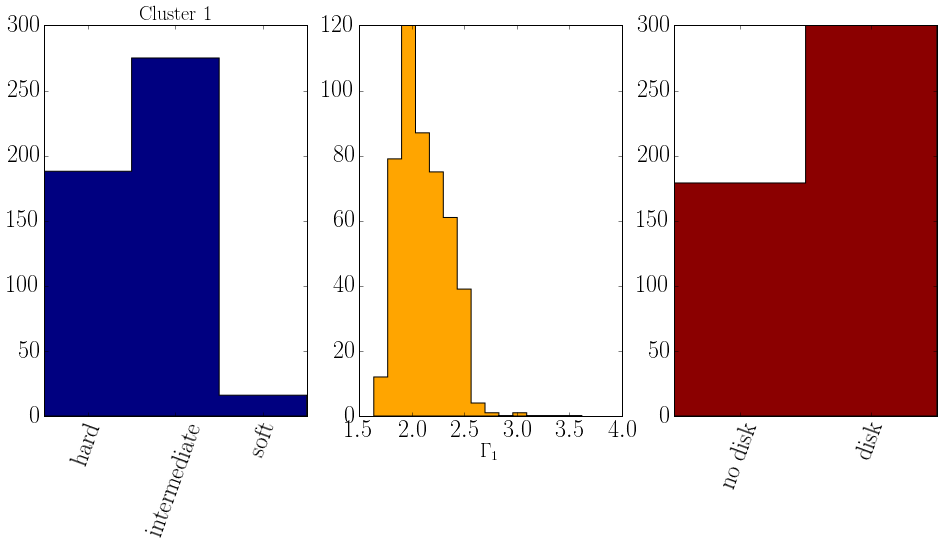

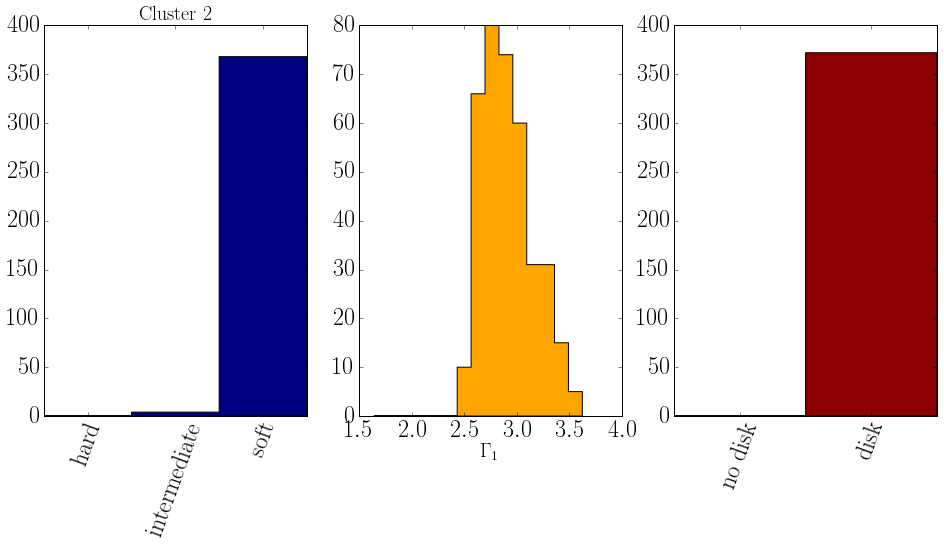

In [64]:
for p in pred_label_set:
    mymembers = pred_labels_gmm == p
    pstates = states[0,mymembers]
    pgammas = gammas[mymembers]
    pdisk = disk[mymembers]
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(131)
    ax.hist(pstates, bins=3, range=[0.5,3.5], histtype="stepfilled", color="navy")
    ax.set_title("Cluster %s"%p)
    plt.xticks([1, 2, 3], ["hard", "intermediate", "soft"], rotation=70)
    ax2 = fig.add_subplot(132)
    ax2.hist(pgammas, bins=15, range=[np.min(gammas), np.max(gammas)],color="orange", histtype="stepfilled")
    ax2.set_xlabel("$\Gamma_1$")
    ax3 = fig.add_subplot(133)
    ax3.hist(pdisk+1, bins=2, range=[0.5,2.5], histtype="stepfilled", color="darkred")
    plt.xticks([1, 2], ["no disk", "disk"], rotation=70)



It looks like the cut between the hard and the intermediate state is pretty clear, whereas the cut between intermediate and soft state is not. Victoria says that $\Gamma_1 = 2.0$ is exactly where models with disk dominate models without disk, but modelling the disk is a tricky business. It would be cool if we could make statements about the presence of a disk without actual spectra modelling, just from clustering!

## Are our Features Gaussian in shape?

Before we go ahead and fit GMMs, we're going to check whether our features are Gaussian at all.
We will do this by simply plotting all the features in a large grid and see whether their histograms come 
out vaguely Gaussian.


In [118]:
import seaborn as sns
feature_names = ["rms1", "rms2", "rms3", "rms4", "PC1", "Timelag", "Coherence", "intensity", "HR1", "HR2", "HR3", "HR4",
                 "CR1", "CR2", "CR3", "CR4", "PC Comp1", "PC Comp2"]


def plot_features(features_new_all, labels_all, feature_names, nrows, ncolumns, datadir="./", froot="grs1915_features_"):
    labels_unique = list(set(labels_all))

    for lab in labels_unique:
        fl = np.array([f for f,l in zip(features_new_all, labels_all) if l == lab])

        fig = plt.figure(figsize=(17,13))


        sns.set_style("white")

        ax = fig.add_subplot(111)
        # Turn off axis lines and ticks of the big subplot

        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

        sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 16, "text.usetex":True, "font.family":"serif"})
        sns.set_style("darkgrid")
        plt.rc("text", usetex=True)
        plt.rc("axes", titlesize=20, labelsize=20) 
        plt.rc("font", size=24, family="serif", serif="Computer Sans")

        for i,fn in enumerate(feature_names):
            f = fl[:,i]
            ax1 = fig.add_subplot(nrows, ncolumns, i+1)
            ax1.hist(f, bins=15, histtype="stepfilled")
            ax1.set_xlabel(fn)
            #ax1.set_ylabel("p( " + fn + ")")
            #ax1.get_xaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))
            #ax1.get_yaxis().set_major_formatter(plt.LogFormatter(10,  labelOnlyBase=False))

        ax.set_title("Human class: " + str(lab))
        plt.savefig(datadir+froot+"_%s.pdf"%str(lab), format="pdf")
        plt.close()
    return
plot_features(features[:,1:], states[0,:], feature_names, nrows=5,ncolumns=4, datadir="./", froot="cygx1_features_")
#plot_features(features_new_all, labels_all, feature_names, datadir=datadir)


Plotting the human labels:

In [85]:
colors = np.array(colors)

(0, 1936)

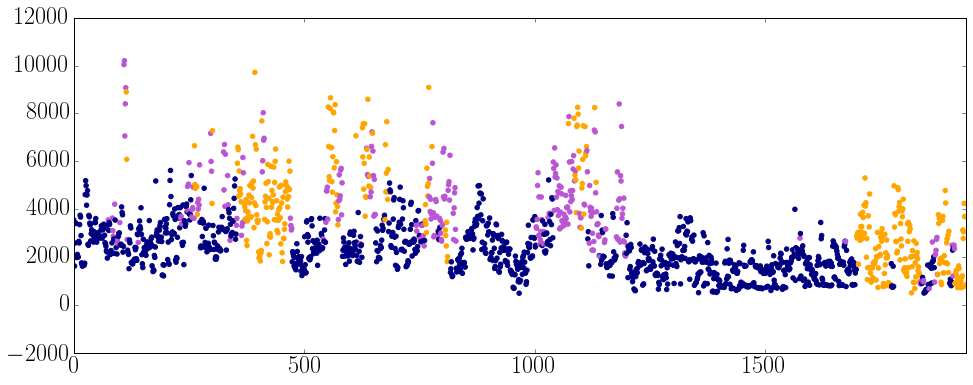

In [86]:
states_indices = np.array([int(s) for s in states[0]])
plt.figure(figsize=(16,6))
plt.scatter(np.arange(intensity.shape[1]), intensity.T, color=colors[states_indices])
plt.xlim(0, intensity.shape[1])

(0, 1936)

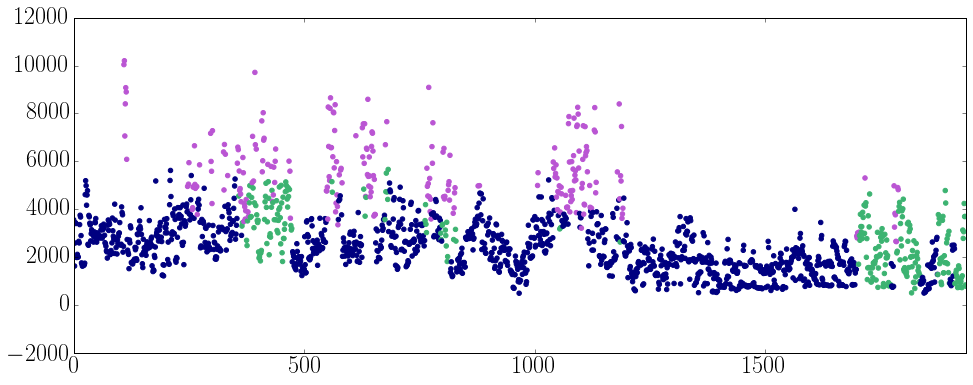

In [71]:
plt.figure(figsize=(16,6))
plt.scatter(np.arange(intensity.shape[1]), intensity.T, color=cnew_kmeans)
plt.xlim(0, intensity.shape[1])

### HMM



Looking at covariance type diag


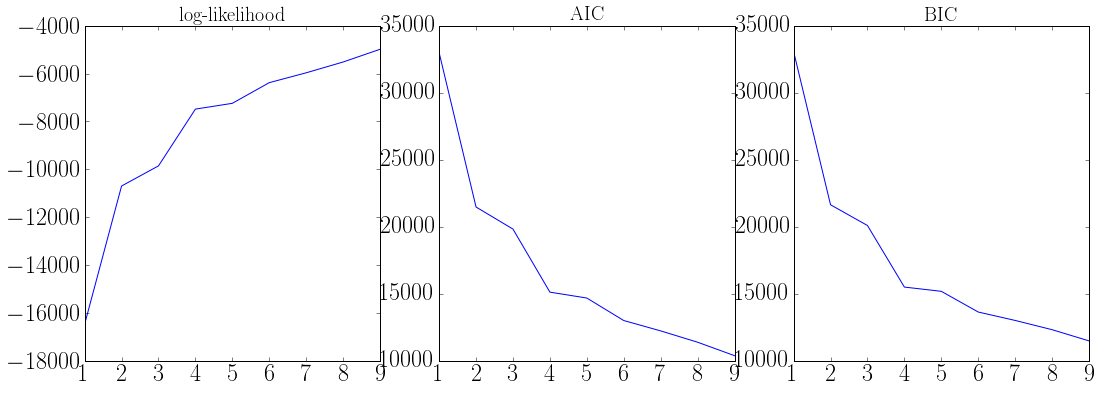

In [94]:
from hmmlearn import hmm

score_all, bic_all, aic_all = [], [], []

max_comp = 10
n_components = range(1,max_comp,1)

for c in ["diag"]:
    print("\n======================================")
    print("Looking at covariance type %s"%c)
    score_temp, aic_temp, bic_temp = [], [], []
    for n in n_components:
        model2 = hmm.GaussianHMM(n_components=n, covariance_type=c)
        model2.fit(fscaled_new) 
        score_temp.append(model2.score(fscaled_new))
        aic_temp.append(model2.aic(fscaled_new))
        bic_temp.append(model2.bic(fscaled_new))
    score_all.append(score_temp)
    aic_all.append(aic_temp)
    bic_all.append(bic_temp)
    plt.figure(figsize=(18,6))
    plt.subplot(131)
    plt.plot(n_components, score_temp)
    plt.title("log-likelihood")
    plt.subplot(132)
    plt.plot(n_components, aic_temp)
    plt.title("AIC")
    plt.subplot(133)
    plt.plot(n_components, bic_temp)
    plt.title("BIC")
    plt.show()

In [1]:
model2 = hmm.GaussianHMM(n_components=5, covariance_type="full")
model2.fit(fscaled_new)
pred_labels_hmm = model2.predict(fscaled_new)
cnew_hmm = np.array([col])

NameError: name 'hmm' is not defined

(0, 1936)

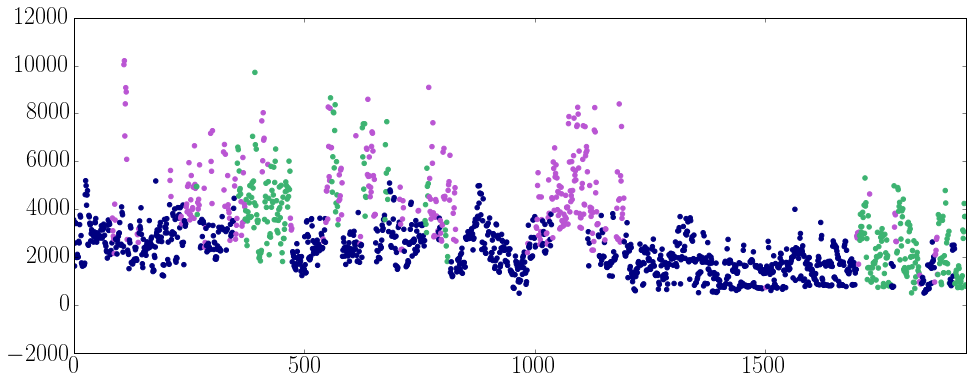

In [106]:
cnew_hmm = np.array([colors[int(i)] for i in pred_labels_hmm])

plt.figure(figsize=(16,6))
plt.scatter(np.arange(intensity.shape[1]), intensity.T, color=cnew_hmm)
plt.xlim(0, intensity.shape[1])

In [108]:
np.log()

array([[ 0.94951275,  0.0098221 ,  0.04066515],
       [ 0.00272795,  0.97289088,  0.02438117],
       [ 0.03671555,  0.08705225,  0.8762322 ]])

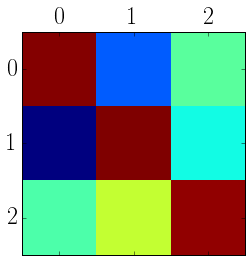

In [112]:
plt.matshow(np.log10(model2.transmat_))


In [113]:
print("state 0: intermediate")
print("state 1: hard")
print("state 2: soft")

state 0: intermediate
state 1: hard
state 2: soft


## Estimating the Number of Clusters via Gaussian Mixture Models

We're going to need a state-indepentend way to evaluate our performance, i.e. one that doesn't include the "ground truth". The easiest way I can think of is a GMM, comparing the individual states with the BIC, but there may be better ways I don't know about. For now, let's do that!

In [18]:
from sklearn.mixture import GMM
n_classes = 10
covar_type = "full"

bic_all = []
pred_labels_all = []
for n in range(1,n_classes, 1):
    gmmc = GMM(n_components=n, covariance_type=covar_type, n_iter=100)
    gmmc.fit(fscaled)
    bic = gmmc.bic(fscaled)
    bic_all.append(bic)
    pred_labels = gmmc.predict(fscaled)
    pred_labels_all.append(pred_labels)

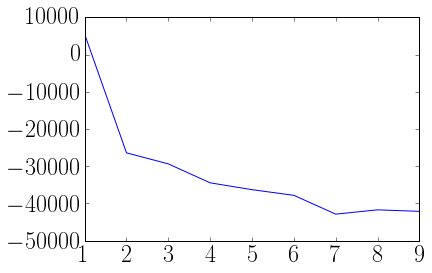

In [19]:
plt.plot(range(1,n_classes,1), bic_all)

In [20]:
pl = pred_labels_all[6]

In [21]:

p = figure(title = "Cygnus X-1, t-SNE plot with human labels",
           #x_axis_label = "Time in MET seconds",
           #y_axis_label = "Counts per bin?",
           #background_fill="lightgrey",
           tools="pan,wheel_zoom,box_zoom,reset,hover")

colors = ["magenta", "cyan", "orange", "mediumseagreen", "purple"]#, "yellow", "brown", "cyan", "orange", "black"]


colors = ["mediumseagreen", "navy", "mediumorchid", "orange", "sienna", "teal", "goldenrod", "grey", "black"]
cnew = [colors[int(i)] for i in pl]

source = ColumnDataSource(data=d)  


p.scatter(x=asdf[:,0], y=asdf[:,1], source=source, size=4, fill_color=cnew, line_color=cnew, alpha=0.5)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [("block name", "@blockname"),
                  ("Start Time", "@tstart"),
                  ("State", "@states"),
                ("Gamma_1","@gammas"),
                ("Timelag","@timelag"),
                ("Coherence", "@coherence"),
                ("Intensity", "@intensity"),
                ("HR1", "@hr1"),
                ("HR2", "@hr2"),
                ("HR3", "@hr3"),
                ("HR4", "@hr4"),
                ]

#misclassifieds = np.where(pred_labels+1. != features[:,0])
show(p)

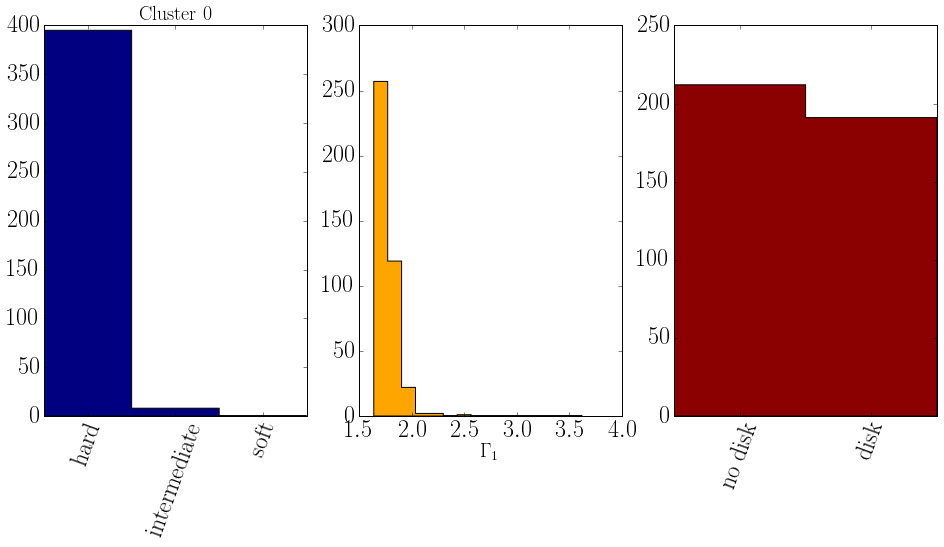

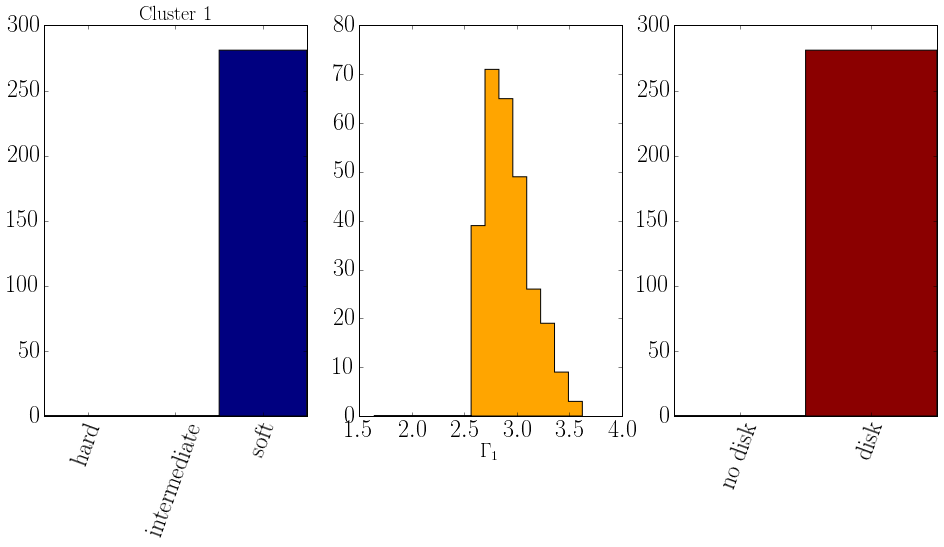

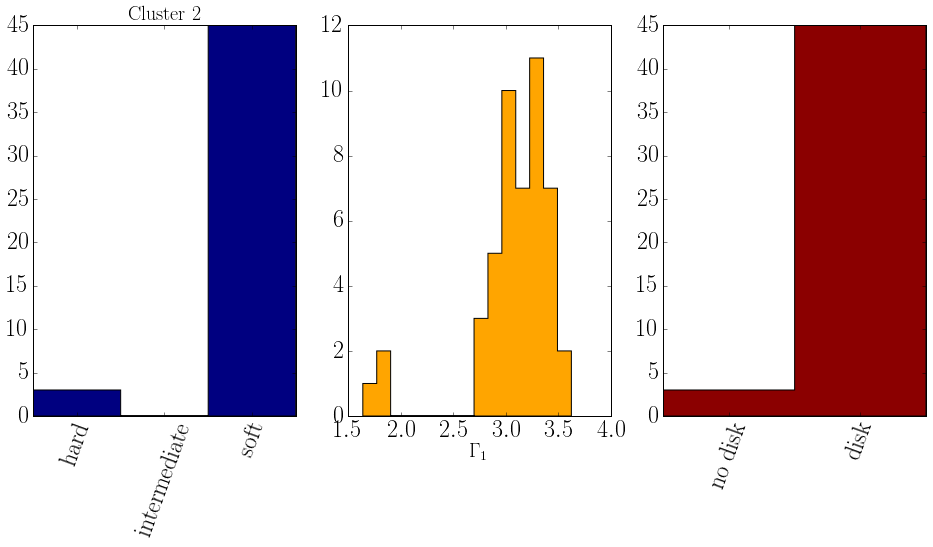

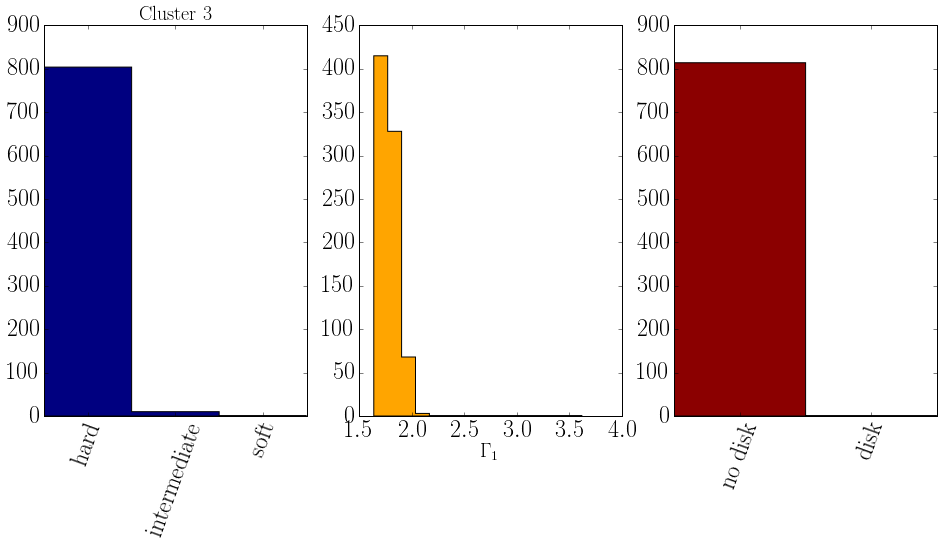

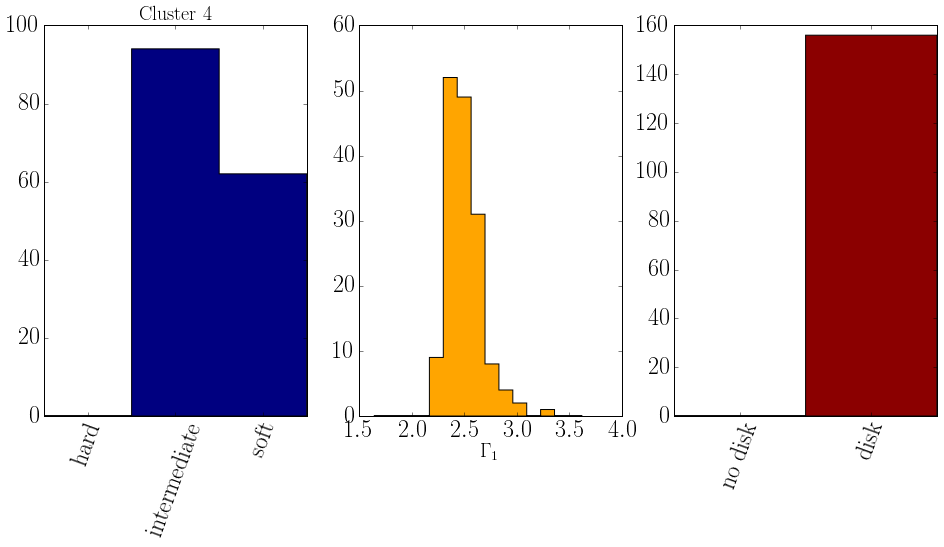

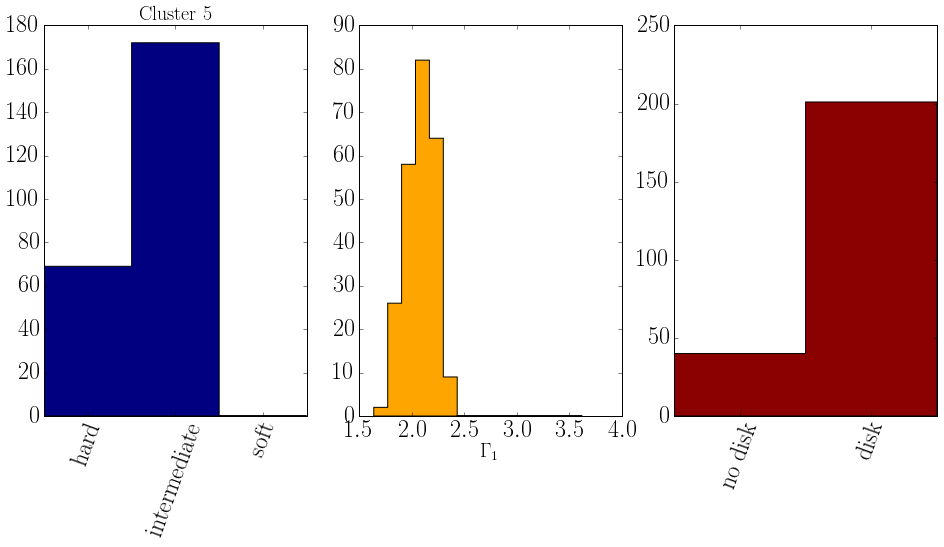

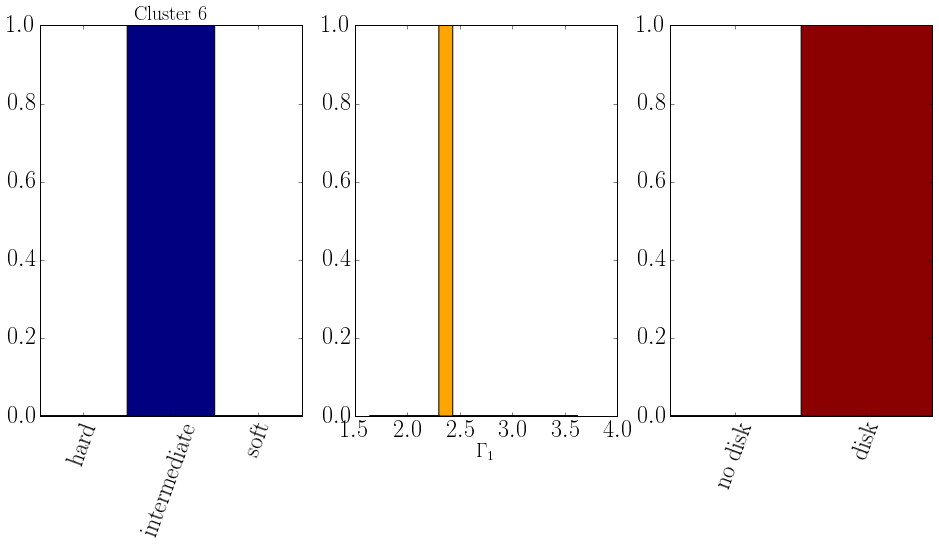

In [22]:
pred_label_set = list(set(pl))
for p in pred_label_set:
    mymembers = pl == p
    pstates = states[0,mymembers]
    pgammas = gammas[mymembers]
    pdisk = disk[mymembers]
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(131)
    ax.hist(pstates, bins=3, range=[0.5,3.5], histtype="stepfilled", color="navy")
    ax.set_title("Cluster %s"%p)
    plt.xticks([1, 2, 3], ["hard", "intermediate", "soft"], rotation=70)
    ax2 = fig.add_subplot(132)
    ax2.hist(pgammas, bins=15, range=[np.min(gammas), np.max(gammas)],color="orange", histtype="stepfilled")
    ax2.set_xlabel("$\Gamma_1$")
    ax3 = fig.add_subplot(133)
    ax3.hist(pdisk+1, bins=2, range=[0.5,2.5], histtype="stepfilled", color="darkred")
    plt.xticks([1, 2], ["no disk", "disk"], rotation=70)



In [137]:
#fig = plt.figure(figsize=(16,8))
#ax = fig.add_subplot(111)
#ax.scatter(tstart, intensity, c=cnew)

p = figure(title = "Cygnus X-1, t-SNE plot with human labels",
           #x_axis_label = "Time in MET seconds",
           #y_axis_label = "Counts per bin?",
           #background_fill="lightgrey",
           tools="pan,wheel_zoom,box_zoom,reset,hover")

#colors = sns.color_palette("hls", 8)
colors = ["magenta", "cyan", "orange", "mediumseagreen", "purple"]#, "yellow", "brown", "cyan", "orange", "black"]

cnew = [colors[int(i)] for i in pred_labels]


p.scatter(x= tstart, y=intensity[0,:], size=4, fill_color=cnew, line_color=cnew, alpha=0.5)
show(p)